In [1]:
# For loading Packages
import pandas as pd

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# For mathematical calculations
import numpy as np

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

# To build and evaluate model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.tree import plot_tree, DecisionTreeClassifier

import tensorflow as tf
# To ignore any warnings
import warnings
warnings.filterwarnings("ignore")


In [4]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
df_train2= df_train.copy().drop(['Transported'],axis=1)
df_train2=df_train2.dropna()
data = pd.concat([df_train2, df_test], axis = 0).reset_index(drop = True)

data.shape

(10883, 13)

In [5]:
# Data from the Cabin
data[["CabinDeck", "CabinNo.", "CabinSide"]] = data["Cabin"].str.split('/', expand = True)

In [6]:
data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,CabinDeck,CabinNo.,CabinSide
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,F,1,S


In [7]:
data.isnull().sum().sort_values(ascending=False)

FoodCourt       106
Spa             101
Cabin           100
CabinDeck       100
CabinNo.        100
CabinSide       100
ShoppingMall     98
Name             94
CryoSleep        93
VIP              93
Destination      92
Age              91
HomePlanet       87
RoomService      82
VRDeck           80
PassengerId       0
dtype: int64

In [8]:
missing_categorical_columns = data.select_dtypes(include=['object','bool']).isna().sum() > 0
missing_categorical_columns = list(missing_categorical_columns[missing_categorical_columns].index)


print(f'imputed columns: {missing_categorical_columns}')

for col in missing_categorical_columns:
    data[col] = data[col].fillna(data[col].mode()[0])

imputed columns: ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name', 'CabinDeck', 'CabinNo.', 'CabinSide']


In [9]:
data.isnull().sum().sort_values(ascending=False)

FoodCourt       106
Spa             101
ShoppingMall     98
Age              91
RoomService      82
VRDeck           80
PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin             0
Destination       0
VIP               0
Name              0
CabinDeck         0
CabinNo.          0
CabinSide         0
dtype: int64

In [10]:
missing_numerical_columns = data.select_dtypes(include=['int','float64']).isna().sum() > 0
missing_numerical_columns = list(missing_numerical_columns[missing_numerical_columns].index)

print(missing_numerical_columns)

for col in missing_numerical_columns:
    data[col] = data[col].fillna(data[col].mean())

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']


In [11]:
data.isnull().sum().sort_values(ascending=False)

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
CabinDeck       0
CabinNo.        0
CabinSide       0
dtype: int64

In [12]:
full_train = pd.merge(data, df_train[['PassengerId','Transported']], on='PassengerId', how='left')
full_train


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,CabinDeck,CabinNo.,CabinSide,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.000000,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,B,0,P,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.000000,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,F,0,S,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.000000,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,A,0,S,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.000000,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,A,0,S,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.000000,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,F,1,S,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10878,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.000000,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,G,1496,S,NaN
10879,9269_01,Earth,False,G/160/P,TRAPPIST-1e,42.000000,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,F,82,S,NaN
10880,9271_01,Mars,True,D/296/P,55 Cancri e,28.802539,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,D,296,P,NaN
10881,9273_01,Europa,False,D/297/P,TRAPPIST-1e,28.802539,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,D,297,P,NaN


In [13]:
full_tran = full_train.drop(columns = ['PassengerId','Cabin','Name','CabinNo.'])

In [14]:
train_full = full_tran.loc[full_tran['Transported'].notnull()]
test_full = full_tran.loc[full_tran['Transported'].isnull()]

In [15]:
print(train_full.shape)
print(test_full.shape)

(6606, 13)
(4277, 13)


In [16]:
train_full.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinDeck,CabinSide,Transported
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,B,P,False
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,F,S,True
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,A,S,False
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,A,S,False
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,F,S,True


In [17]:
X = train_full.drop(columns='Transported')

In [18]:
numerical_columns = X.select_dtypes(include=['int','float64']).columns
categorical_columns = X.select_dtypes(include=['object','boolean']).columns
print(numerical_columns)
print(categorical_columns)

Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], dtype='object')
Index(['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'CabinDeck',
       'CabinSide'],
      dtype='object')


In [19]:
X_encoded = pd.get_dummies(X, columns=categorical_columns)


In [20]:
X_encoded

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_False,VIP_True,CabinDeck_A,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinSide_P,CabinSide_S
0,39.0,0.0,0.0,0.0,0.0,0.0,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0
1,24.0,109.0,9.0,25.0,549.0,44.0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1
2,58.0,43.0,3576.0,0.0,6715.0,49.0,0,1,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1
3,33.0,0.0,1283.0,371.0,3329.0,193.0,0,1,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1
4,16.0,303.0,70.0,151.0,565.0,2.0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6601,41.0,0.0,6819.0,0.0,1643.0,74.0,0,1,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0
6602,18.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1
6603,26.0,0.0,0.0,1872.0,1.0,0.0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1
6604,32.0,0.0,1049.0,0.0,353.0,3235.0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1


In [21]:
y = train_full['Transported']
y = y.astype(int)

In [22]:
model = DecisionTreeClassifier()

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=78)

In [24]:
model = model.fit(X_train, y_train)

In [25]:
predictions = model.predict(X_test)

In [26]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [27]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,588,208
Actual 1,206,650


Accuracy Score : 0.7493946731234867
Classification Report
              precision    recall  f1-score   support

           0       0.74      0.74      0.74       796
           1       0.76      0.76      0.76       856

    accuracy                           0.75      1652
   macro avg       0.75      0.75      0.75      1652
weighted avg       0.75      0.75      0.75      1652



In [28]:
model_2 = DecisionTreeClassifier( min_samples_split=800, random_state=40, max_depth=5)
model_2.fit(X_train, y_train)
predictions = model_2.predict(X_test)


print(classification_report(y_test, predictions))

plt.figure(figsize=(96,96))
plot_tree(model_2, feature_names=X_encoded.columns, class_names=('Not Transported', 'Transported'))
plt.show()

              precision    recall  f1-score   support

           0       0.79      0.70      0.74       796
           1       0.75      0.83      0.79       856

    accuracy                           0.77      1652
   macro avg       0.77      0.77      0.77      1652
weighted avg       0.77      0.77      0.77      1652



In [29]:
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

display(cm_df)

,Predicted 0,Predicted 1
Actual 0,558,238
Actual 1,144,712


In [30]:
baseline_model = RandomForestClassifier(random_state = 1)
baseline_model.fit(X_encoded, y)

RandomForestClassifier(random_state=1)

In [31]:
# store accuracy of baseline model prediction in results
result = cross_val_score(baseline_model, X_encoded, y, cv = 5, scoring = "accuracy")

# print mean and standard deviation of baseline model
print(np.mean(result))
print(np.std(result))

0.792918764837989
0.0126138761964643


In [32]:
X_pred = test_full.drop(columns="Transported")
X_pred

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinDeck,CabinSide
6606,Earth,True,TRAPPIST-1e,27.000000,False,0.0,0.0,0.0,0.0,0.0,G,S
6607,Earth,False,TRAPPIST-1e,19.000000,False,0.0,9.0,0.0,2823.0,0.0,F,S
6608,Europa,True,55 Cancri e,31.000000,False,0.0,0.0,0.0,0.0,0.0,C,S
6609,Europa,False,TRAPPIST-1e,38.000000,False,0.0,6652.0,0.0,181.0,585.0,C,S
6610,Earth,False,TRAPPIST-1e,20.000000,False,10.0,0.0,635.0,0.0,0.0,F,S
...,...,...,...,...,...,...,...,...,...,...,...,...
10878,Earth,True,TRAPPIST-1e,34.000000,False,0.0,0.0,0.0,0.0,0.0,G,S
10879,Earth,False,TRAPPIST-1e,42.000000,False,0.0,847.0,17.0,10.0,144.0,F,S
10880,Mars,True,55 Cancri e,28.802539,False,0.0,0.0,0.0,0.0,0.0,D,P
10881,Europa,False,TRAPPIST-1e,28.802539,False,0.0,2680.0,0.0,0.0,523.0,D,P


In [33]:
X_pred_encoded = pd.get_dummies(X_pred, columns=categorical_columns)
X_pred_encoded

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_False,VIP_True,CabinDeck_A,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinSide_P,CabinSide_S
6606,27.000000,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1
6607,19.000000,0.0,9.0,0.0,2823.0,0.0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1
6608,31.000000,0.0,0.0,0.0,0.0,0.0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1
6609,38.000000,0.0,6652.0,0.0,181.0,585.0,0,1,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1
6610,20.000000,10.0,0.0,635.0,0.0,0.0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10878,34.000000,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1
10879,42.000000,0.0,847.0,17.0,10.0,144.0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1
10880,28.802539,0.0,0.0,0.0,0.0,0.0,0,0,1,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0
10881,28.802539,0.0,2680.0,0.0,0.0,523.0,0,1,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0


In [34]:
tree_preds = baseline_model.predict(X_pred_encoded)

In [35]:
tree_preds = pd.DataFrame(tree_preds.astype(bool))
tree_preds

,0
0,True
1,False
2,True
3,True
4,False
...,...
4272,True
4273,False
4274,True
4275,True


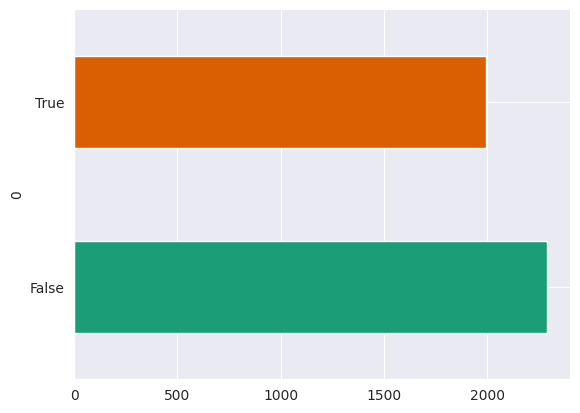

In [36]:

tree_preds.groupby(0).size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [37]:
df_sub = df_test.merge(tree_preds, left_index=True, right_index=True)
df_sub = df_sub.rename(columns={0:'Transported'})
df_submit = df_sub[['PassengerId','Transported']]
df_submit.set_index('PassengerId', inplace=True)
df_submit.to_csv('predictions_tree_base.csv')

In [38]:
df_submit.head()

,Transported
PassengerId,
0013_01,True
0018_01,False
0019_01,True
0021_01,True
0023_01,False


## Kaggle Result: 78.98 the model needs optimization, and we should treat the null values instead of dropping them

# Neural Network

In [39]:
X = train_full.drop(columns='Transported')
y = train_full['Transported']
y = y.astype(int)

In [40]:
X

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinDeck,CabinSide
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,B,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,F,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,A,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,A,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,F,S
...,...,...,...,...,...,...,...,...,...,...,...,...
6601,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,A,P
6602,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,G,S
6603,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,G,S
6604,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,E,S


In [41]:
y

0       0
1       1
2       0
3       0
4       1
       ..
6601    0
6602    0
6603    1
6604    0
6605    1
Name: Transported, Length: 6606, dtype: int64

In [42]:
numerical_columns = X.select_dtypes(include=['int','float64']).columns
categorical_columns = X.select_dtypes(include=['object','boolean']).columns

print(numerical_columns)
print(categorical_columns)

Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], dtype='object')
Index(['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'CabinDeck',
       'CabinSide'],
      dtype='object')


In [43]:
preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        ('numeric', StandardScaler(), numerical_columns)
        ])

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [45]:
X_train = preprocessor.fit_transform(X_train)
X_test  = preprocessor.transform(X_test)
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.524438,-0.342722,-0.285568,-0.305010,0.201266,-0.258215
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.268272,-0.342722,0.304832,-0.305010,-0.277562,-0.268749
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.130372,2.240828,-0.283200,-0.264337,-0.277562,-0.268749
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.268272,-0.342722,-0.285568,-0.305010,-0.277562,-0.268749
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.110736,-0.342722,-0.285568,-0.305010,-0.277562,-0.268749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5279,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.076480,-0.342722,-0.285568,-0.305010,-0.277562,-0.268749
5280,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.475124,0.263483,-0.285568,0.027158,-0.277562,-0.158142
5281,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-0.613024,-0.342722,-0.285568,-0.305010,-0.277562,-0.268749
5282,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.475124,-0.128056,1.417533,0.037327,-0.274921,-0.268749


In [47]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(units=40, activation='relu', input_shape=(X_train.shape[1],)),
  tf.keras.layers.Dense(units=20, activation='relu'),
    tf.keras.layers.Dense(units=20, activation='relu'),
  tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 40)                1080      
                                                                 
 dense_5 (Dense)             (None, 20)                820       
                                                                 
 dense_6 (Dense)             (None, 20)                420       
                                                                 
 dense_7 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2341 (9.14 KB)
Trainable params: 2341 (9.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [48]:
history = model.fit(X_train, y_train, epochs=100, verbose=True)

Epoch 1/100
166/166 [==============================] - 3s 10ms/step - loss: 0.5671 - accuracy: 0.7144
Epoch 2/100
166/166 [==============================] - 1s 6ms/step - loss: 0.4224 - accuracy: 0.7973
Epoch 3/100
166/166 [==============================] - 1s 4ms/step - loss: 0.4065 - accuracy: 0.8047
Epoch 4/100
166/166 [==============================] - 1s 5ms/step - loss: 0.4000 - accuracy: 0.8058
Epoch 5/100
166/166 [==============================] - 1s 6ms/step - loss: 0.3974 - accuracy: 0.8125
Epoch 6/100
166/166 [==============================] - 1s 5ms/step - loss: 0.3931 - accuracy: 0.8109
Epoch 7/100
166/166 [==============================] - 1s 4ms/step - loss: 0.3907 - accuracy: 0.8117
Epoch 8/100
166/166 [==============================] - 1s 5ms/step - loss: 0.3867 - accuracy: 0.8117
Epoch 9/100
166/166 [==============================] - 1s 4ms/step - loss: 0.3857 - accuracy: 0.8113
Epoch 10/100
166/166 [==============================] - 1s 5ms/step - loss: 0.3818 - accur

In [49]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

42/42 [==============================] - 0s 2ms/step - loss: 0.4963 - accuracy: 0.8011
Test accuracy: 0.8010590076446533, Test loss: 0.49628594517707825


In [50]:
X = preprocessor.fit_transform(X)
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.695413,-0.345756,-0.285355,-0.309494,-0.273759,-0.269534
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.336769,-0.176748,-0.279993,-0.266112,0.206165,-0.230494
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.002842,-0.279083,1.845163,-0.309494,5.596357,-0.226058
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.282540,-0.345756,0.479034,0.334285,2.636384,-0.098291
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.887266,0.124056,-0.243650,-0.047470,0.220152,-0.267759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6601,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.833037,-0.345756,3.777285,-0.309494,1.162518,-0.203876
6602,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-0.749641,-0.345756,-0.285355,-0.309494,-0.273759,-0.269534
6603,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-0.199145,-0.345756,-0.285355,2.938900,-0.272885,-0.269534
6604,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.213728,-0.345756,0.339621,-0.309494,0.034826,2.600774


In [51]:
model.fit(X,y,epochs=100, verbose=True )

Epoch 1/100
207/207 [==============================] - 1s 2ms/step - loss: 0.3391 - accuracy: 0.8426
Epoch 2/100
207/207 [==============================] - 0s 2ms/step - loss: 0.3289 - accuracy: 0.8426
Epoch 3/100
207/207 [==============================] - 1s 2ms/step - loss: 0.3253 - accuracy: 0.8417
Epoch 4/100
207/207 [==============================] - 0s 2ms/step - loss: 0.3244 - accuracy: 0.8423
Epoch 5/100
207/207 [==============================] - 1s 3ms/step - loss: 0.3221 - accuracy: 0.8406
Epoch 6/100
207/207 [==============================] - 1s 3ms/step - loss: 0.3192 - accuracy: 0.8448
Epoch 7/100
207/207 [==============================] - 1s 4ms/step - loss: 0.3170 - accuracy: 0.8430
Epoch 8/100
207/207 [==============================] - 1s 4ms/step - loss: 0.3167 - accuracy: 0.8451
Epoch 9/100
207/207 [==============================] - 1s 3ms/step - loss: 0.3161 - accuracy: 0.8439
Epoch 10/100
207/207 [==============================] - 0s 2ms/step - loss: 0.3178 - accura

In [52]:
X_pred = test_full.drop(columns="Transported")
X_pred

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinDeck,CabinSide
6606,Earth,True,TRAPPIST-1e,27.000000,False,0.0,0.0,0.0,0.0,0.0,G,S
6607,Earth,False,TRAPPIST-1e,19.000000,False,0.0,9.0,0.0,2823.0,0.0,F,S
6608,Europa,True,55 Cancri e,31.000000,False,0.0,0.0,0.0,0.0,0.0,C,S
6609,Europa,False,TRAPPIST-1e,38.000000,False,0.0,6652.0,0.0,181.0,585.0,C,S
6610,Earth,False,TRAPPIST-1e,20.000000,False,10.0,0.0,635.0,0.0,0.0,F,S
...,...,...,...,...,...,...,...,...,...,...,...,...
10878,Earth,True,TRAPPIST-1e,34.000000,False,0.0,0.0,0.0,0.0,0.0,G,S
10879,Earth,False,TRAPPIST-1e,42.000000,False,0.0,847.0,17.0,10.0,144.0,F,S
10880,Mars,True,55 Cancri e,28.802539,False,0.0,0.0,0.0,0.0,0.0,D,P
10881,Europa,False,TRAPPIST-1e,28.802539,False,0.0,2680.0,0.0,0.0,523.0,D,P


In [53]:
X_pred = preprocessor.transform(X_pred)
pd.DataFrame(X_pred)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-0.130333,-0.345756,-0.285355,-0.309494,-0.273759,-0.269534
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.680829,-0.345756,-0.279993,-0.309494,2.194050,-0.269534
2,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.144916,-0.345756,-0.285355,-0.309494,-0.273759,-0.269534
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.626600,-0.345756,3.677789,-0.309494,-0.115533,0.249517
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.612017,-0.330251,-0.285355,0.792392,-0.273759,-0.269534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.351352,-0.345756,-0.285355,-0.309494,-0.273759,-0.269534
4273,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.901849,-0.345756,0.219273,-0.279994,-0.265018,-0.141768
4274,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.006296,-0.345756,-0.285355,-0.309494,-0.273759,-0.269534
4275,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.006296,-0.345756,1.311342,-0.309494,-0.273759,0.194507


In [54]:
predictions = (model.predict(X_pred)[:,0]>0.5).astype(bool)

134/134 [==============================] - 1s 4ms/step


In [55]:
pred_nn=pd.DataFrame(predictions)
pred_nn

,0
0,True
1,False
2,True
3,True
4,True
...,...
4272,True
4273,True
4274,True
4275,True


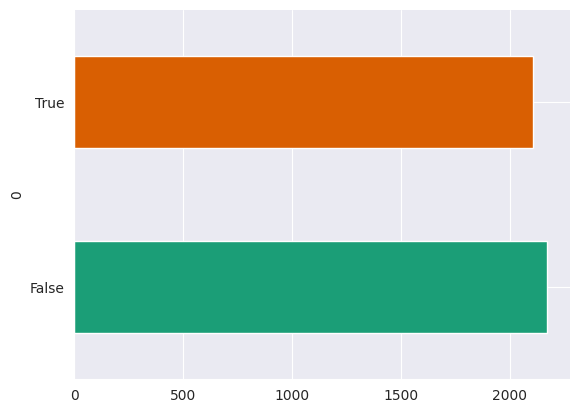

In [56]:

pred_nn.groupby(0).size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [57]:
df_test

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale


In [58]:
df_sub = df_test.merge(pred_nn, left_index=True, right_index=True)
df_sub = df_sub.rename(columns={0:'Transported'})
df_submit = df_sub[['PassengerId','Transported']]
df_submit.set_index('PassengerId', inplace=True)
df_submit.to_csv('predictions_nn_1.csv')

## Kaggle result: 77.76% accuracy, the nn model is probably overfitted